Overview:
- Parsing using twitter api and alpha vantage
- Cleaning, EDA
- Models

Conclusion:


## Import


In [21]:
# Parsing
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.cryptocurrencies import CryptoCurrencies
from alpha_vantage.techindicators import TechIndicators

# Data processing
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_theme(style="whitegrid") # all charts will have a light grid
# from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist

# Text Preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords 
# nltk.download('stopwords')
# nltk.download('words')
words = set(nltk.corpus.words.words())
import spacy
from spacy import displacy

# Text valuation/detection
import langid
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA


# Misc
import os
import glob
import warnings
warnings.filterwarnings("ignore")



## Functions

In [22]:
# remove stopwords and puncturations
def get_text_processing(text):
    stpword = stopwords.words('english')
    stpword.remove('not')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

# Check if each word is english word
def engOnly(x):
    a = " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words ) #or not w.isalpha()
    return a

# remove url
def remove_url(txt):
    return " ".join(re.sub("([-a-zA-Z0-9@:%_\+.~#?&//=]{2,256}\.[a-z]{2,4}\b(\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?)", "", txt).split())
#remove hashtag #
def remove_hashtag(txt):
    return " ".join(re.sub("([#＃]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)", "", txt).split())
# remove mention @
def remove_at(txt):
    return " ".join(re.sub("(\@[a-zA-Z0-9_%]*)", "", txt).split())
# Remove names from text
def removeName(x):
    names = ['twtr', 'twitter', 'rt','elon','musk']
    new_text = []
    for a in x:
        if a.lower() not in names:
            new_text.append(a.lower())
    return new_text

def remove3(a):
    x = remove_at(a)
    x = remove_hashtag(x)
    x = remove_url(x)
    return x
    
# detect language - Note: may not be most accurate
def lanDetectFunc(x):
    a = langid.classify(x)
    return a[0]

# function detect bot
def botDetect(x):
    if 'bot' in x:
        return True
        
# only get dates
def convTime(x):
    x = x[:10]
    return x


######################### API Keys #########################
# Load key for tweepy
path = r'C:\Users\Gumo\Desktop\Git\Notebook\keys\tweepy.txt'
keys = []
with open(path, mode='r') as w:
    for line in w:
        keys.append(line.split(': ')[1].strip())
access_token = keys[3]
access_secret = keys[4]
consumer_key = keys[0]
consumer_secret = keys[1]
bearer_token = keys[2]

###### my id/name #####
myUserId = 1309643764172947456
myUsername = 'stockjanitor'

# Load Twitter API
# Twitter API v1 - auth keys (Cursor)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_secret)

# create instance
twitterApi = tweepy.API(auth, wait_on_rate_limit=True)
# wait on rate limit, not to get errors on timing out

# verify credential
try:
    # see if credential works
    twitterApi.verify_credentials()
    print("twitterApi works")
except:
    print("Please fix me")

# Variable - store Alpha Vantage API key
path =  r'C:\Users\Gumo\Desktop\Git\Notebook\keys\alphaVantage.txt'
with open(path, mode='r') as w:
    alphaKey = (w.readline())

################################################## API Functions ##################################################
###### Twitter FUNCTIONS ######
def tweetPost(text):
    try:
        twitterApi.update_status(text)
        print("bling bling~~")
    except:
        print("boom boom")
def tweetMedia(text, img):
    try:
        media = twitterApi.media_upload(img)
        twitterApi.update_status(text,media_ids=[media.media_id_string])
        print("bling bling~~")
    except:
        print("boom boom")
def tweetFriend(name):
    try:
        twitterApi.create_friendship(screen_name=name)
        print("bling bling~~")
    except:
        print("boom boom")
def tweetUnfriend(name):
    try:
        twitterApi.destroy_friendship(screen_name=name)
        print("bling bling~~")
    except:
        print("boom boom")

# Function AlphaVantage
def alpha(key, symbol, function, period=None, typ = None, tim=None, outputsize = 'compact'):
    
    # Funciton - TimeSeries
    if function == 't':
        # Instance - TimeSeries Instance
        ts = TimeSeries(key = key, output_format='pandas')
        if period == 'd':
            data = ts.get_daily(symbol, outputsize=outputsize)[0]
        elif period == 'w':
            data = ts.get_weekly_adjusted(symbol)[0]
        elif period == 'm':
            data = ts.get_monthly_adjusted(symbol)[0]

    # Funciton - FundamentalData
    elif function == 'f':
        # Instance - FundamentalData Instance
        fd = FundamentalData(key, output_format='pandas')
        if period == 'q':
            if typ == 'i':
                data = fd.get_income_statement_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ == 'b':
                data = fd.get_balance_sheet_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ=='c':
                data = fd.get_cash_flow_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
        elif period =='a':
            if typ == 'i':
                data = fd.get_income_statement_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ == 'b':
                data = fd.get_balance_sheet_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ=='c':
                data = fd.get_cash_flow_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
    
    # Funciton - TechnicalIndicator            
    elif function =='ti':
        ti = TechIndicators(key,output_format='pandas')

        # reassign period into TI format
        if period == 'm':
            period = 'monthly'
        elif period =='w':
            period = 'weekly'
        elif period == 'd':
            period ='daily'

        if typ == 'rsi':
            data=ti.get_rsi(symbol,interval=period,time_period=tim,series_type='close')[0]
        elif typ =='so':
            data = ti.get_stoch(symbol,interval=period)[0]
            
    # Funciton - CC
    elif function == 'c':
        # Instance - Crypto
        cc = CryptoCurrencies(key, output_format='pandas')
        pass
    return data

twitterApi works


## Parsing

In [42]:
# Tweepy Parsing
query1 = "#twtr"
hour = '01'

date = '20220530'
time =hour+'00'
time2='2359'
fromdate =date+time
todate=date+time2

######################## Search 30 Day Queries ########################
# store search in tweets
queryResponse1 = twitterApi.search_30_day(label='30Days',query=query1,fromDate=fromdate,toDate=todate,maxResults=100)
# save tweets to list1
list1 = [[tweet.user.screen_name,tweet.text,tweet.created_at,tweet.user.location,tweet.source,tweet.favorite_count,tweet.quote_count,tweet.reply_count,tweet.retweet_count]for tweet in queryResponse1]
# convert tweet list into dataframe
df = pd.DataFrame(data=list1,columns=['user','text','time','location','source','like_count','quote_count','reply_count','retweet_count'])
# save to dataframe
df.to_csv('data_tweets/'+date+time+time2+query1+'.csv')
df.shape



######################## Search Recent queries ########################
# sincedate=''
# queryResponse1 = twitterApi.search_tweets(q=query1,until=sincedate,count=100)
# # items = 5, retrieve 5 tweets
# list1 = [[tweet.user.screen_name,tweet.text,tweet.created_at,tweet.user.location,tweet.source,tweet.favorite_count,tweet.retweet_count]for tweet in queryResponse1]
# # convert tweet list into dataframe
# df = pd.DataFrame(data=list1,columns=['user','text','time','location','source','like_count','retweet_count'])
# # save to dataframe
# df.to_csv('data/'+sincedate+query1+'.csv')
# df.shape

(54, 9)

In [52]:
# Alpha Vantage Parsing
# Variable Size (compact or full)
outputsize = 'compact'

# Variable Stock
symbol = 'twtr'

# Variable Function - t, f, c, ti (timeseries, financialdata, crypto, technical indicator)
function = 't'

# Variable Period
# TimeSeries: d,w,m,i (daily, weekly, monthly, interval(mins))
# Fundamental: q,a (quarterly,annually)
# Technical: d,w,m, (interval(mins))
period = 'd'

# Varible - Type
# Fundamental: i,b,c (income statement, balance sheet, cashflow)
# Technical: so,rsi
typ ='so'

# Varible - Time
tim = 60

info = alpha(alphaKey,symbol,function,period=period,typ = typ,tim=tim, outputsize='full')
info.head()



,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2022-05-31,40.07,40.3500,39.42,39.60,11154668.0
2022-05-27,39.57,40.7700,39.48,40.17,16789855.0
2022-05-26,38.52,39.5899,38.23,39.52,22968398.0
2022-05-25,36.06,37.3700,36.02,37.16,23262766.0
2022-05-24,36.94,37.2026,35.40,35.76,22662972.0


In [55]:
# save to local stock data
info.to_csv('data_stock/'+symbol.upper()+'stockPrice.csv')

In [56]:
info.tail()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2013-11-13,41.03,42.87,40.760,42.60,8688300.0
2013-11-12,43.66,43.78,41.830,41.90,6316700.0
2013-11-11,40.50,43.00,39.400,42.90,16113900.0
2013-11-08,45.93,46.94,40.685,41.65,27925300.0
2013-11-07,45.10,50.09,44.000,44.90,117701600.0


## Load/Clean Data

In [57]:
pathOfData = 'data_tweets/' 
# saves path all file name to variable all_files
all_files2 = glob.glob(os.path.join(pathOfData , "*.csv"))
#initiate a list
merged_list2 = []

# loop all files to append each file to list
for b in all_files2:
    df = pd.read_csv(b, index_col=None, header=0)
    merged_list2.append(df)

# concat all files
merged_df2 = pd.concat(merged_list2, axis=0, ignore_index=True)
merged_df2.shape

(2385, 10)

In [58]:
merged_df2.head(3)

,Unnamed: 0,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count
0,0,topstonks,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01 23:17:26+00:00,NaN,topstonks,0,0,0,0
1,1,Samxxgold,New investors trying to understand the Stock M...,2022-05-01 23:11:23+00:00,"St Paul, MN",Twitter for iPhone,0,0,0,0
2,2,Ralphtan222,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01 23:01:45+00:00,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0


In [61]:
master_df = merged_df2
# convert to string
master_df['bot'] = master_df['source'].apply(lambda x: botDetect(x.lower()))
master_df.head()

,Unnamed: 0,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count,bot
0,0,topstonks,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01 23:17:26+00:00,NaN,topstonks,0,0,0,0,None
1,1,Samxxgold,New investors trying to understand the Stock M...,2022-05-01 23:11:23+00:00,"St Paul, MN",Twitter for iPhone,0,0,0,0,None
2,2,Ralphtan222,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01 23:01:45+00:00,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0,None
3,3,ScottGraffius,RT @ScottGraffius: The lifespan (half-life) 🕟 ...,2022-05-01 20:44:02+00:00,California,Twitter Web App,0,0,0,0,None
4,4,Idacrypto1,Who else is going long on #TWTR #ElonMusk #Bul...,2022-05-01 20:09:10+00:00,NaN,Twitter for Android,0,0,0,0,None


In [62]:
# count num of bots
master_df.bot.value_counts()

True    47
Name: bot, dtype: int64

In [66]:
# save to df, drop bot, drop bot column, reset index
master_df1 = master_df[master_df['bot'] != True].iloc[:,0:-1].reset_index(drop=True)
master_df1.columns

Index(['Unnamed: 0', 'user', 'text', 'time', 'location', 'source',
       'like_count', 'quote_count', 'reply_count', 'retweet_count'],
      dtype='object')

In [68]:
master_df2 = master_df1.iloc[:,1:]
master_df2.columns

Index(['user', 'text', 'time', 'location', 'source', 'like_count',
       'quote_count', 'reply_count', 'retweet_count'],
      dtype='object')

In [70]:
# assign new df
master_df3 = master_df2

# df2 has time converted convert time
master_df3['time'] = master_df2['time'].apply(lambda x: convTime(x))
master_df3.head()

,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count
0,topstonks,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01,NaN,topstonks,0,0,0,0
1,Samxxgold,New investors trying to understand the Stock M...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0
2,Ralphtan222,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0
3,ScottGraffius,RT @ScottGraffius: The lifespan (half-life) 🕟 ...,2022-05-01,California,Twitter Web App,0,0,0,0
4,Idacrypto1,Who else is going long on #TWTR #ElonMusk #Bul...,2022-05-01,NaN,Twitter for Android,0,0,0,0


In [73]:
# converting source to prepare piechart
sourceCount_df = pd.DataFrame(master_df3.source.value_counts()).reset_index()
sourceCount_df.rename(columns={"index": "sourcename"}, inplace=True)
# store sourcename
sourcelist= list(sourceCount_df.sourcename.head(6))
# convert source names
def sourceConv(x):
    if x in sourcelist:
        return str(x)
    else:
        return 'Others'

sourceCount_df["sourcename2"] = sourceCount_df['sourcename'].apply(lambda x: sourceConv(x))

#groupby new srouce name, reset index
sourceCount_df = sourceCount_df.groupby('sourcename2').sum().reset_index()
# calculate percent
sourceCount_df["percent"] = sourceCount_df['source'].apply(lambda x: x/sourceCount_df['source'].sum())
sourceCount_df = sourceCount_df.sort_values(by=['source'])
sourceCount_df

,sourcename2,source,percent
4,Twitter for iPad,23,0.009837
6,topstonks,38,0.016253
0,LinkedIn,43,0.018392
1,Others,165,0.070573
3,Twitter for Android,343,0.146707
5,Twitter for iPhone,709,0.303251
2,Twitter Web App,1017,0.434987


Text(0.5, 1.0, 'Sources')

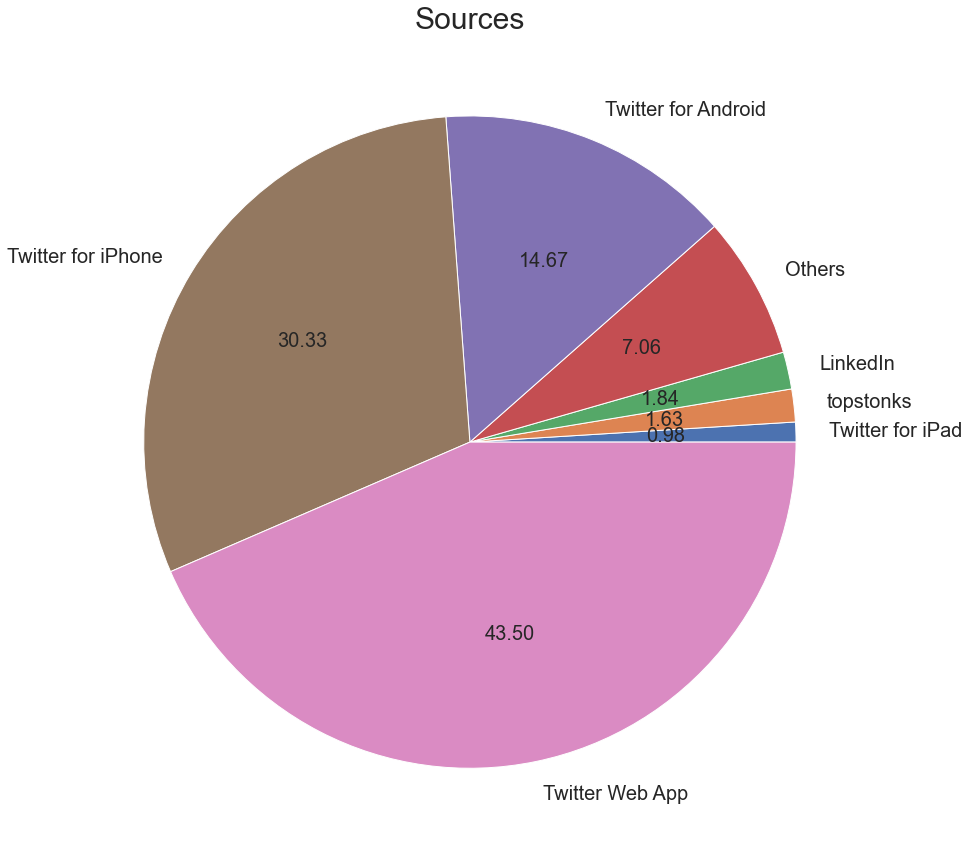

In [76]:

mpl.rcParams['font.size'] = 25
# plot chart
plt.figure(figsize=(15,15))
# realize dont need percent, pie chat calculates for you
plt.pie(sourceCount_df.source, labels=sourceCount_df.sourcename2, autopct='%.2f',textprops= {"fontsize":20})
plt.title('Sources', fontsize=30)

In [82]:
# # recently had huge retweet, i wanted to see what the message was
# retweet_df = master_df3.sort_values(by='retweet_count',ascending=False)
# retweet_df.head()

In [88]:
master_df4 = master_df3
# detect language
master_df4['lang'] = master_df3.text.apply(lambda x :lanDetectFunc(x))
master_df4.head()
# master_df3['translateText'] = master_df3['text'].apply(translator1.translate, dest='en').apply(getattr, args=('text',))

,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,topstonks,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01,NaN,topstonks,0,0,0,0,en
1,Samxxgold,New investors trying to understand the Stock M...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en
2,Ralphtan222,(要人の声明があった様)\n\nvia @Forbes \n#news #TWTR #Elo...,2022-05-01,DeCenterized Tokyo🗼⇄NY🗽,Twitter for iPhone,0,0,1,0,ja
3,ScottGraffius,RT @ScottGraffius: The lifespan (half-life) 🕟 ...,2022-05-01,California,Twitter Web App,0,0,0,0,en
4,Idacrypto1,Who else is going long on #TWTR #ElonMusk #Bul...,2022-05-01,NaN,Twitter for Android,0,0,0,0,en


In [163]:
master_df4.lang.value_counts().head()

en    1697
ar     143
tr      55
es      54
ja      50
Name: lang, dtype: int64

In [153]:
# make new df, select only en
master_df5 = master_df4[master_df4.lang =='en']
master_df5.head(2)

,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,topstonks,$TWTR was the 8th most mentioned on wallstreet...,2022-05-01,NaN,topstonks,0,0,0,0,en
1,Samxxgold,New investors trying to understand the Stock M...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en


In [154]:
# assign new df
master_df6 = master_df5
# apply remove3 function
master_df6.text = master_df6.text.apply(remove3)

master_df6['text'] = master_df6.text.apply(lambda x : removeName(x.split()))
master_df6.head(1)

,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,topstonks,"[was, the, 8th, most, mentioned, on, wallstree...",2022-05-01,NaN,topstonks,0,0,0,0,en


In [155]:
# join text as sentence
master_df6['text'] = master_df6.text.apply(lambda x : ' '.join(x))
master_df6.head()

,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,topstonks,was the 8th most mentioned on wallstreetbets o...,2022-05-01,NaN,topstonks,0,0,0,0,en
1,Samxxgold,new investors trying to understand the stock m...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en
3,ScottGraffius,the lifespan halflife of posts on and other so...,2022-05-01,California,Twitter Web App,0,0,0,0,en
4,Idacrypto1,who else is going long on musk,2022-05-01,NaN,Twitter for Android,0,0,0,0,en
5,fred_promos,prediction tomorrows predicted price 485 20220...,2022-05-01,NaN,Twitter for iPhone,0,0,0,0,en


In [156]:
# remove stopwords and puncturations
master_df6['text'] = master_df6.text.apply(lambda x : get_text_processing(x))
master_df6.head()

,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count,lang
0,topstonks,8th mentioned wallstreetbets last 7 days via,2022-05-01,NaN,topstonks,0,0,0,0,en
1,Samxxgold,new investors trying understand stock market p...,2022-05-01,"St Paul, MN",Twitter for iPhone,0,0,0,0,en
3,ScottGraffius,lifespan halflife posts social media platforms...,2022-05-01,California,Twitter Web App,0,0,0,0,en
4,Idacrypto1,else going long musk,2022-05-01,NaN,Twitter for Android,0,0,0,0,en
5,fred_promos,prediction tomorrows predicted price 485 20220...,2022-05-01,NaN,Twitter for iPhone,0,0,0,0,en


In [157]:
# obtain unique tweets
master_df7 = master_df6.drop_duplicates(subset='text',keep='last')
master_df7.shape
# list # obtain word pool of unique tweets
wordpool = list(master_df7.text)
# string - joiin each sentence
wordpool3 = ' '.join(wordpool)
# list of words - split into words
wordpool2 = wordpool3.split(' ')
len(wordpool2)

11980

In [158]:
wordcountset = FreqDist(wordpool2)
wordcountset.most_common(20)

[('soap', 187),
 ('musk', 154),
 ('elon', 137),
 ('nft', 126),
 ('tsla', 119),
 ('btc', 115),
 ('via', 100),
 ('buy', 84),
 ('stock', 74),
 ('made', 74),
 ('hand', 70),
 ('not', 67),
 ('aloe', 60),
 ('check', 58),
 ('like', 54),
 ('vera', 53),
 ('get', 50),
 ('market', 44),
 ('deal', 44),
 ('price', 42)]

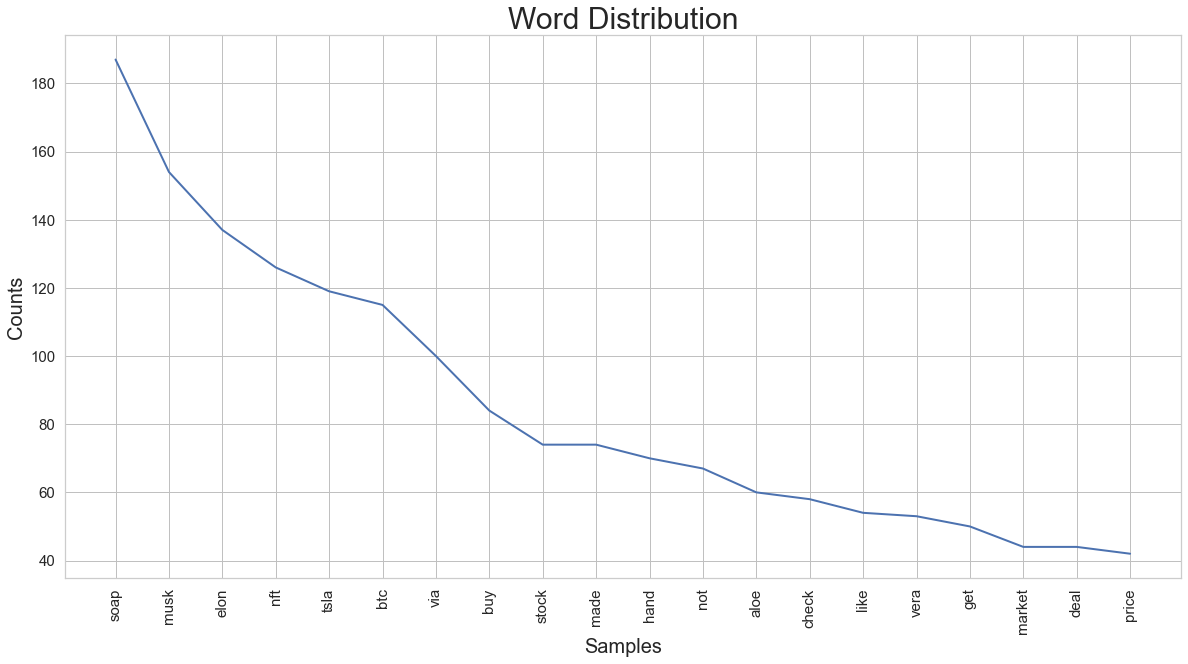

<AxesSubplot:title={'center':'Word Distribution'}, xlabel='Samples', ylabel='Counts'>

In [159]:
plt.figure(figsize=(20,10))
# Annotation
plt.xlabel('Words', fontsize=20)
plt.ylabel('Counts', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Word Distribution', fontsize=30)
wordcountset.plot(20)

In [ ]:
wc = WordCloud(background_color='white', max_words=100, stopwords = STOPWORDS)

# Generate and plot wordcloud
plt.figure(figsize=(20,10))
plt.imshow(wc.generate(wordpool3))
plt.axis('off')
plt.show()

In [162]:
nlp = spacy.load('en_core_web_lg')

# list # obtain word pool of unique tweets
nerpool = list(master_df7.text)
# string - joiin each sentence
nerpool2 = ';'.join(nerpool)

doc_q = nlp(nerpool2)

displacy.render(doc_q, style='ent', jupyter=True)

## Part 2